# LAB 4: Topic modeling

Use topic models to explore hotel reviews

Objectives:
* tokenize with MWEs using spacy
* estimate LDA topic models with tomotopy
* visualize and evaluate topic models
* apply topic models to interpretation of hotel reviews

## Analyze reviews

In [1]:
import pandas as pd
import numpy as np
from cytoolz import *
from tqdm.auto import tqdm
tqdm.pandas()

### Read in hotel review data and tokenize it

In [2]:
df = pd.read_parquet('hotels.parquet')

In [3]:
import tomotopy as tp

mdl = tp.LDAModel.load('hotel-topics.bin')

In [4]:
df[df['overall']==1]['name'].value_counts().head(20)

Hotel Pennsylvania New York                      1358
Hotel Carter                                      685
Hudson New York                                   486
Park Central                                      330
The Boston Park Plaza Hotel & Towers              238
W New York                                        233
The Roosevelt Hotel                               206
Edison Hotel Times Square                         195
Wellington Hotel                                  178
Paradise Point Resort & Spa                       169
Waldorf Astoria New York                          168
Milford Plaza Hotel                               157
Town and Country Resort Hotel                     157
Manhattan Broadway Hotel                          147
Doubletree Hotel Metropolitan - New York City     145
Grand Hyatt New York                              145
Le Parker Meridien                                144
Fort Rapids Indoor Waterpark Resort               143
New York Inn                

Pick a hotel with a lot of 1 star ratings (other than the Paradise Point Resort & Spa) and pull out all of its reviews

In [5]:
subdf = df[df['name']=='Park Central']

In [6]:
subdf['overall'].value_counts()

4.0    826
5.0    576
3.0    450
1.0    330
2.0    313
Name: overall, dtype: int64

Tokenize

In [7]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(open('hotel-terms.txt'))

In [8]:
subdf['tokens'] = subdf['text'].progress_apply(tokenizer.tokenize)

  0%|          | 0/2495 [00:00<?, ?it/s]

<ipython-input-8-639ec7ac7f3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['tokens'] = subdf['text'].progress_apply(tokenizer.tokenize)


### Apply topic model

In [9]:
subdf['docs'] = [mdl.make_doc(words=toks) for toks in subdf['tokens']]

<ipython-input-9-4ea85f0a2328>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['docs'] = [mdl.make_doc(words=toks) for toks in subdf['tokens']]


In [10]:
topic_dist, ll = mdl.infer(subdf['docs'])

### Interpret model

What topics are associated with a review?

In [11]:
subdf['text'].iloc[0]

'Bedbugs!!!! No acknowledgement, no bill adjustment, just fill out a form for Security. I showed the manager a bite, and I am still itching like crazy! Only where my body was in contact with the bed did I have bites.'

In [12]:
subdf.iloc[0]

title                                              “BEDBUGS !!!!!”
text             Bedbugs!!!! No acknowledgement, no bill adjust...
date_stayed                                          December 2012
date                                           2012-12-18 00:00:00
service                                                        1.0
cleanliness                                                    2.0
overall                                                        2.0
value                                                          2.0
location                                                       4.0
sleep_quality                                                  2.0
rooms                                                          3.0
locality                                             New York City
name                                                  Park Central
tokens           [bedbugs, no, acknowledgement, no, bill, adjus...
docs             (bedbugs, no, acknowledgement, no, bill, adju

In [13]:
subdf['docs'].iloc[0].get_topics(top_n=5)

[(59, 0.2456667274236679),
 (17, 0.20325155556201935),
 (71, 0.12880782783031464),
 (24, 0.04824015870690346),
 (45, 0.04616584628820419)]

In [15]:
mdl.get_topic_words(59)

[('reservation', 0.025148451328277588),
 ('told', 0.020067248493433),
 ('after', 0.016495680436491966),
 ('called', 0.015335840173065662),
 ('charged', 0.012445446103811264),
 ('booked', 0.011966782622039318),
 ('made', 0.011653809808194637),
 ('check', 0.011396068148314953),
 ('credit_card', 0.011175146326422691),
 ('them', 0.010991044342517853)]

In [16]:
mdl.get_topic_words(17)

[('bed', 0.12981025874614716),
 ('pillows', 0.04975196719169617),
 ('sleep', 0.03396835923194885),
 ('mattress', 0.03378831967711449),
 ('sheets', 0.030007455497980118),
 ('beds', 0.024666234850883484),
 ('slept', 0.020285233855247498),
 ('soft', 0.018424808979034424),
 ('down', 0.017824672162532806),
 ('pillow', 0.01692446693778038)]

In [17]:
mdl.get_topic_words(71)

[('your', 0.0426035076379776),
 ('make', 0.02303205616772175),
 ('am', 0.02218112163245678),
 ('go', 0.020777083933353424),
 ('sure', 0.019614141434431076),
 ('their', 0.015855856239795685),
 ('really', 0.01448018103837967),
 ('what', 0.013586701825261116),
 ('back', 0.012891773134469986),
 ('want', 0.012551399879157543)]

In [18]:
mdl.get_topic_words(24)

[('their', 0.02383425645530224),
 ('even', 0.01650250144302845),
 ('any', 0.013548444025218487),
 ('guests', 0.01293153315782547),
 ('what', 0.012812895700335503),
 ('should', 0.012658667750656605),
 ('service', 0.012433257885277271),
 ('never', 0.011068934574723244),
 ('experience', 0.009360563941299915),
 ('say', 0.00767592154443264)]

What are the most common topics?

In [19]:
subdf['topics'] = [list(map(first, d.get_topics(3))) for d in subdf['docs']]

<ipython-input-19-b8d81d74ac29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['topics'] = [list(map(first, d.get_topics(3))) for d in subdf['docs']]


In [20]:
subdf['topics']

72543    [59, 17, 71]
72544     [1, 44, 90]
72545    [43, 12, 28]
72546     [69, 91, 1]
72547    [31, 11, 12]
             ...     
75033    [65, 92, 97]
75034    [69, 71, 15]
75035    [12, 18, 69]
75036    [63, 14, 74]
75037    [30, 59, 24]
Name: topics, Length: 2495, dtype: object

In [21]:
from collections import Counter

In [22]:
topic_freq = Counter(concat(subdf['topics']))
print(f'Top Freq Words')
for t, c in topic_freq.most_common(20):
    print(f'{t:3d} {c:4d}', ', '.join(map(first, mdl.get_topic_words(t))))

Top Freq Words
 12  476 nyc, times_square, subway, central_park, broadway, street, manhattan, blocks, new_york, away
 24  301 their, even, any, guests, what, should, service, never, experience, say
 65  297 new_york, times_square, nyc, subway, ny, empire_state_building, manhattan, fantastic, really, its
 69  278 friendly, recommend, helpful, definitely, comfortable, really, loved, back, beds, great_location
 50  260 dirty, bathroom, carpet, bed, place, old, sheets, looked, been, off
 34  259 back, got, went, after, down, called, front_desk, told, them, then
  1  230 made, feel, make, their, every, home, way, always, who, went
 36  228 reception, nights, really, lovely, although, breakfast, helpful, found, after, having
 70  224 small, bit, quite, breakfast, overall, ok, fine, nothing, price, although
 11  219 check, arrived, early, after, p.m., ready, a.m., until, before, 3
 31  210 reviews, read, after, some, other, reading, booked, based, before, negative
 78  191 service, recommend,

Most common topics in 1 star reviews?

In [23]:
topic_freq = Counter(concat(subdf[subdf['overall']==1]['topics']))
print(f'Top Freq Words')
for t, c in topic_freq.most_common(20):
    print(f'{t:3d} {c:4d}', ', '.join(map(first, mdl.get_topic_words(t))))

Top Freq Words
 50  129 dirty, bathroom, carpet, bed, place, old, sheets, looked, been, off
 24  123 their, even, any, guests, what, should, service, never, experience, say
 34   77 back, got, went, after, down, called, front_desk, told, them, then
 59   75 reservation, told, after, called, charged, booked, made, check, credit_card, them
 35   33 front_desk, another, after, moved, given, offered, upon, asked, told, called
 55   33 towels, day, housekeeping, left, them, cleaned, never, after, front_desk, cleaning
 11   32 check, arrived, early, after, p.m., ready, a.m., until, before, 3
 71   29 your, make, am, go, sure, their, really, what, back, want
 93   28 he, his, him, said, asked, told, manager, husband, who, went
 20   21 what, really, place, got, else, think, nothing, say, more, bad
 45   18 am, 'd, because, some, more, been, sure, really, since, even
 73   18 elevator, elevators, floor, lobby, down, wait, slow, people, stairs, long
 90   17 been, always, has, years, times, tim

Most common topics in 5 star reviews?

In [24]:
topic_freq = Counter(concat(subdf[subdf['overall']==5]['topics']))
print(f'Top Freq Words')
for t, c in topic_freq.most_common(20):
    print(f'{t:3d} {c:4d}', ', '.join(map(first, mdl.get_topic_words(t))))

Top Freq Words
 12  157 nyc, times_square, subway, central_park, broadway, street, manhattan, blocks, new_york, away
 69  131 friendly, recommend, helpful, definitely, comfortable, really, loved, back, beds, great_location
  1  127 made, feel, make, their, every, home, way, always, who, went
 65   98 new_york, times_square, nyc, subway, ny, empire_state_building, manhattan, fantastic, really, its
 78   86 service, recommend, excellent, friendly, helpful, highly, comfortable, extremely, experience, professional
 36   53 reception, nights, really, lovely, although, breakfast, helpful, found, after, having
 31   53 reviews, read, after, some, other, reading, booked, based, before, negative
 90   50 been, always, has, years, times, time, many, several, over, am
 11   49 check, arrived, early, after, p.m., ready, a.m., until, before, 3
 71   48 your, make, am, go, sure, their, really, what, back, want
 37   39 restaurants, within, walking_distance, close, many, shopping, friendly, helpful, 

### Report

Finish this notebook by writing a brief report to the hotel managers describing what you've found in the reviews of their hotel, along with some actionable advice. Use whatever data, charts, word clouds, etc. that you think will help you make your case. 

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

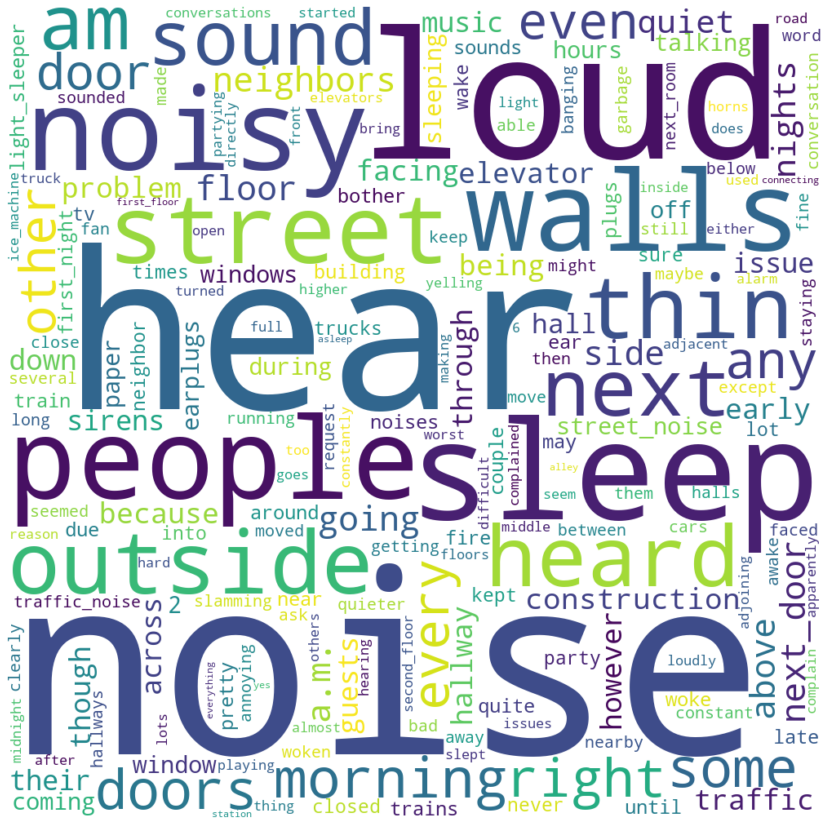

In [26]:
plt.figure(figsize=(15,15))
freqs = dict(mdl.get_topic_words(54, 200))
wc = WordCloud(width=1000,height=1000,background_color='white').generate_from_frequencies(freqs)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.show()

It would seem that the biggest problem that guests have with their experience is noise pollution. The word cloud above shows the most common words found among all guest reviews and clearly there is a large issue with noise. Looking closer into the word cloud we can find the various sources of noise: traffic, construction, neighbors, trains, parties, etc. One solution to this issue would be to soundproof all rooms by, for example, adding more insulation into the walls and installing soundproof glass windows.